In [40]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression

In [41]:
NUM_DAYS = 10000    
INTERVAL = '1d'     
symbol = 'BTC-USD'

[*********************100%***********************]  1 of 1 completed
2669
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  


<AxesSubplot:xlabel='Date'>

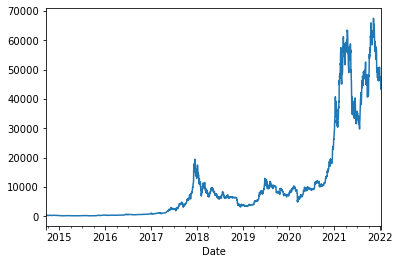

In [42]:
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)

print(len(data))

print(data.head())

data["Close"].plot()

<AxesSubplot:xlabel='Date'>

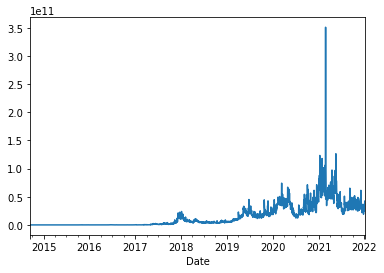

In [43]:
data["Volume"].plot()

<AxesSubplot:xlabel='Date'>

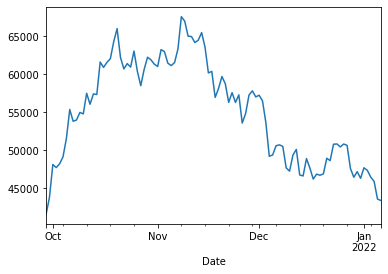

In [44]:
data.iloc[-100:]['Close'].plot()

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  459.194363  459.793251  423.297558  432.968080  432.968080   
2014-09-19  435.363215  438.089849  396.971212  407.044759  407.044759   
2014-09-20  408.511636  428.327342  392.293679  408.271672  408.271672   
2014-09-21  408.232853  417.936894  392.873483  402.096310  402.096310   

                  Volume  
Date                      
2014-09-17  2.105680e+07  
2014-09-18  3.100228e+07  
2014-09-19  3.570002e+07  
2014-09-20  3.646787e+07  
2014-09-21  3.000688e+07  


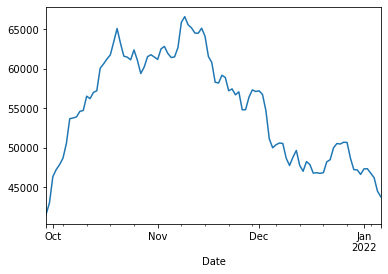

In [45]:
data = data.ewm(alpha=0.65).mean()
data = data.dropna()

data.iloc[-100:]['Close'].plot()

print(data.head())

In [46]:
live_pred_data = data.iloc[-100:-10]
live_pred_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-29,41576.303946,42793.706153,40973.946603,41563.623513,41563.623513,3.060824e+10
2021-09-30,41560.031576,43637.988169,41279.859631,43011.349675,43011.349675,3.095498e+10
2021-10-01,43026.893474,46756.703476,42605.966105,46329.984300,46329.984300,3.868716e+10
2021-10-02,46348.767403,47748.186842,45764.660598,47227.961888,47227.961888,3.343983e+10
2021-10-03,47214.086365,48646.814809,46669.869100,47859.756192,47859.756192,2.901872e+10
...,...,...,...,...,...,...
2021-12-23,48478.323677,50603.808987,47948.169690,49977.532605,49977.532605,2.731772e+10
2021-12-24,49991.346295,51390.450919,49616.281852,50526.563365,50526.563365,2.540035e+10
2021-12-25,50552.667883,51251.446298,50019.558219,50463.705771,50463.705771,2.126004e+10


In [47]:
def _produce_prediction(data, window):
    
    prediction = (data.shift(-window)['Close'] >= data['Close'])
    prediction = prediction.iloc[:-window]
    data['Pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['Close'])
data = data.dropna()
data.tail()
print(len(data))

print(data.tail())


2654
                    Open          High           Low     Adj Close  \
Date                                                                 
2021-12-18  46842.111964  47725.822373  45800.406693  46826.219984   
2021-12-19  46849.752859  47962.319471  46257.061874  46748.737151   
2021-12-20  46757.004126  47597.929002  45816.847242  46834.238276   
2021-12-21  46840.902225  48704.871831  46390.099269  48200.782029   
2021-12-22  48203.429255  49250.823109  47729.646658  48478.806327   

                  Volume  Pred  
Date                            
2021-12-18  2.813044e+10   1.0  
2021-12-19  2.619579e+10   1.0  
2021-12-20  2.929376e+10   0.0  
2021-12-21  2.783909e+10   0.0  
2021-12-22  2.563487e+10   0.0  


In [48]:
y = data['Pred']
features = [x for x in data.columns if x not in ['Pred']]
X = data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.33)

In [49]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test.values, rf_prediction)
print('Random Forest Classifier Accuracy = ' , rf_accuracy , "\n")
print(classification_report(y_test, rf_prediction))

Random Forest Classifier Accuracy =  0.7335581787521079 

              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68       748
         1.0       0.76      0.78      0.77      1031

    accuracy                           0.73      1779
   macro avg       0.73      0.72      0.73      1779
weighted avg       0.73      0.73      0.73      1779



In [50]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test.values, knn_prediction)
print('KNeighbors Classifier Accuracy = ' , knn_accuracy , "\n")
print(classification_report(y_test, knn_prediction))
confusion_matrix_graph = confusion_matrix(y_test, knn_prediction)

KNeighbors Classifier Accuracy =  0.5660483417650365 

              precision    recall  f1-score   support

         0.0       0.48      0.37      0.42       748
         1.0       0.61      0.71      0.65      1031

    accuracy                           0.57      1779
   macro avg       0.54      0.54      0.54      1779
weighted avg       0.55      0.57      0.55      1779



In [51]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test.values, lr_prediction)
print('Logistic Regression Classifier Accuracy = ' , lr_accuracy , "\n")
print(classification_report(y_test, lr_prediction))

Logistic Regression Classifier Accuracy =  0.5795390668915121 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       748
         1.0       0.58      1.00      0.73      1031

    accuracy                           0.58      1779
   macro avg       0.29      0.50      0.37      1779
weighted avg       0.34      0.58      0.43      1779



C:\Users\sefad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sefad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sefad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
